In [1]:
import datetime
import os
import time
import pickle
import wandb
import cv2

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.compat.v1 as tfc
import numpy as np

from PIL import Image,ImageOps
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
from keras import callbacks
from sklearn.metrics import confusion_matrix
from wandb.keras import WandbCallback

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.8)

try: sess.close() 
except: pass
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))
tf.executing_eagerly()


Num GPUs Available:  1
Found GPU at: /device:GPU:0


True

## CONSTANTS

In [3]:
IMG_SIZE = 128
CHANNELS = 1
#INPUT_SHAPE = [IMG_SIZE,int(IMG_SIZE/2),3]
INPUT_SHAPE = [IMG_SIZE,IMG_SIZE,CHANNELS]

BATCH_SIZE = 64
EPOCHS = 300

ROT= 20


NAME = f"O_CNN{int(time.time())}"
SOURCE = "train_images/"
RES = f"train_images_res_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}/"

### TensorBoard + Callbacks

In [4]:
#wandb.tensorboard.patch(root_logdir="logs/")

In [5]:


#%load_ext tensorboard
#%tensorboard --logdir logs

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)

## Adjust CSV

In [6]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


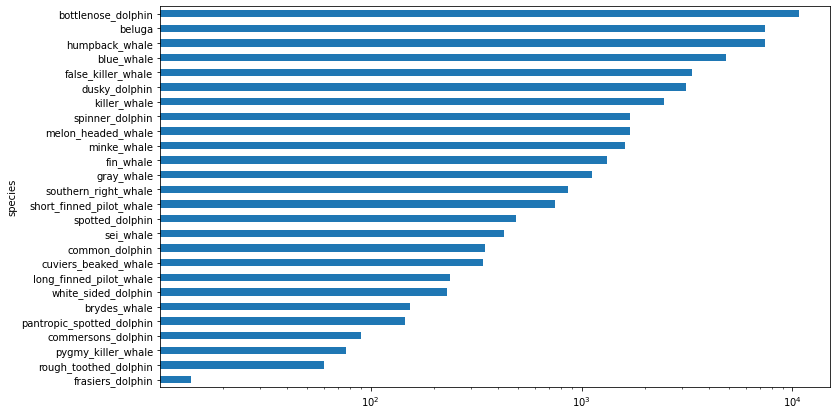

In [7]:
print(f"amount of species: {len(train_df.species.unique())}")
plt.figure(figsize=(12, 7))
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

#### Adjust for class imbalance

In [8]:
thresh = 1000
max_instances = 2000

#train_df.species = train_df.species.apply(lambda x: 'other_dolphin' if ('dolphin' in x and not "bottlenose" in x) else x)
species_counts = train_df['species'].value_counts()



final_species = species_counts[species_counts > thresh].index.tolist()
undersample_species = species_counts[species_counts > max_instances].index.tolist()
mask = train_df.species.apply(lambda x: any(item for item in final_species if item in x))
final_df = train_df[mask]

In [9]:
def undersample(df, index, max_instances):
    sampled = df[df.species == index].sample(n=max_instances, random_state=101) if len(df[df.species == index]) > max_instances else df[df.species == index]
    return  sampled

dfs = []
for species in final_species:
    dfs.append(undersample(final_df,species,max_instances))

final_train_df = pd.concat(dfs,axis=0).sort_index()
final_train_df["species"].value_counts()

train_df=final_train_df

In [10]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
#train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)
#labels = train_df["species"]

##one-hot encode species
labels = pd.get_dummies(train_df.species, prefix='species_')
labels

,species__beluga,species__blue_whale,species__bottlenose_dolphin,species__dusky_dolphin,species__false_killer_whale,species__fin_whale,species__gray_whale,species__humpback_whale,species__killer_whale,species__melon_headed_whale,species__minke_whale,species__spinner_dolphin
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
51013,0,1,0,0,0,0,0,0,0,0,0,0
51017,0,0,0,0,1,0,0,0,0,0,0,0
51020,1,0,0,0,0,0,0,0,0,0,0,0
51021,0,0,0,0,0,0,0,0,0,0,0,1


In [11]:
AMT_CLASSES = labels.shape[1]

## Resize Images
This helps the model fitting --> picture preprocessing gets less intensive

In [12]:
def image_filet(im):
    #Kernel exclusion and image processing
    img = np.asarray(im)
    gauss = cv2.GaussianBlur(img, (0, 0), 2.0)
    img = cv2.addWeighted(img, 1, gauss, 0, 0)
    
    img = cv2.GaussianBlur(img,(9,9),2.0)
    kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
    img = cv2.filter2D(img, -1, kernel)
    return Image.fromarray(img)


if not os.path.exists(RES):
    os.mkdir(RES)
    for image in tqdm(images):
        savePath = RES + image  
        if not os.path.exists(savePath):
            imgPath = SOURCE + image
            im = Image.open(imgPath)
            im = ImageOps.grayscale(im) if CHANNELS == 1 else im
            
            im = image_filet(im)
            
            im.thumbnail((IMG_SIZE,IMG_SIZE), Image.ANTIALIAS)
            im = ImageOps.pad(im, (IMG_SIZE,IMG_SIZE), color='black')
            
            #resizedImage = im.resize((IMG_SIZE, IMG_SIZE), PIL.Image.ANTIALIAS)
            #resizedImage.save(savePath) 
            im.save(savePath)

In [13]:
full_img = list(map(RES.__add__,train_df['image']))

## Input Pipeline

In [14]:
@tf.function
def process_tuple(image,label):
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    

    
    img = tf.image.random_flip_left_right(img)
    
    lower,upper,size,max_delta = 0.1,0.5,0,0
    img = tf.image.random_contrast(img, lower, upper, seed=None)
    #img = tf.image.random_crop(img, size, seed=None, name=None)
    img = tf.image.random_brightness(img, max_delta, seed=None)
    
    #img = tf.keras.preprocessing.image.random_rotation(
        #img, ROT, row_axis=0, col_axis=1, channel_axis=2)
    
    img = tf.image.convert_image_dtype(img, tf.float16) / 255
    return img, label

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((full_img, labels)).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

In [16]:
TRAIN_SPLIT = 0.7
VAL_TEST_SPLIT = (1-TRAIN_SPLIT)/2

image_count = dataset.cardinality().numpy()
train_size = int(image_count*TRAIN_SPLIT)
val_test_size = int(image_count*VAL_TEST_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_test_size)
test_ds = dataset.skip(train_size).skip(val_test_size)


train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_batched = val_ds.batch(batch_size=int(BATCH_SIZE*0.15)).cache().prefetch(tf.data.AUTOTUNE)
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### Benchmark Dataset

In [17]:
#nocnn = new_cnn_oliver.create_model(INPUT_SHAPE, AMT_CLASSES)
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in tqdm(dataset):
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [18]:
benchmark_ds = dataset.take(1)
benchmark(benchmark_ds)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.86it/s]

Execution time: 0.18942799999786075


## Modelling

#### WandB

In [36]:
run = wandb.init(project="my-test-project",
           entity="dolphin_project",
           sync_tensorboard = True,
           config={
               "learning_rate": 0.005,
               "batch_size": BATCH_SIZE,
               "epochs": EPOCHS,
               "input_width": INPUT_SHAPE[0],
               "input_height": INPUT_SHAPE[1],
               "loss_function": "categorical_crossentropy",
               "architecture": "CNN",
               "dataset": "dolphin",
               #"activation": ACTIVATION_STR,
               #"conv_units": [FIRST_CONV_UNITS, SECOND_CONV_UNITS] + CONV_UNITS_BODY,
           })
config = wandb.config

categorical_accuracy,▃▁▅▅█▄
epoch,▁▂▄▅▇█
loss,█▂▂▁▁▁
val_categorical_accuracy,████▁▁
val_loss,▁▄▆▆▇█
best_epoch,0
best_val_loss,2.4708
categorical_accuracy,0.08907
epoch,5
loss,2.47098
val_categorical_accuracy,0.09017


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


#### Model Keras

In [37]:
#import model generators
import stefan_cnn_v2
import oliver_cnn_v1
import sequential_nn
import sequential_nn_c
import new_cnn_oliver
import berkan_cnn

In [38]:
tf.keras.backend.clear_session()

#ocnn = oliver_cnn_v1.create_model(INPUT_SHAPE, AMT_CLASSES)
scnn = stefan_cnn_v2.create_model(INPUT_SHAPE, AMT_CLASSES)
#nocnn = new_cnn_oliver.create_model(INPUT_SHAPE, AMT_CLASSES)
seqnn = sequential_nn.create_model(INPUT_SHAPE, AMT_CLASSES)
nseqnn = sequential_nn.create_model(INPUT_SHAPE, AMT_CLASSES)
bcnn = berkan_cnn.create_model(INPUT_SHAPE, AMT_CLASSES)
    
current_model = nseqnn
    
current_model.summary()
current_model.compile(loss=config.loss_function,#tfa.losses.SigmoidFocalCrossEntropy()
             optimizer=keras.optimizers.Adam(config.learning_rate),
             metrics=['categorical_accuracy']) 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 128, 128, 1)       0         
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               8389120   
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256

In [39]:
history = current_model.fit(train_batched,
                   epochs = EPOCHS,
                   validation_data = val_batched,
                   callbacks=[WandbCallback(input_type="image",  labels=list(labels.columns)),
                              TensorBoard(log_dir=wandb.run.dir),
                              #WandbClassificationCallback(log_confusion_matrix=True, validation_data=val_batched, labels=list(range(AMT_CLASSES))),
                              earlystopping                           
                             ])
wandb.watch(history)

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Epoch 1/300
234/235 [============================>.] - ETA: 0s - loss: 2.0932 - categorical_accuracy: 0.2219

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


235/235 [==============================] - 10s 38ms/step - loss: 2.0926 - categorical_accuracy: 0.2220 - val_loss: 1.9455 - val_categorical_accuracy: 0.2721
Epoch 2/300
235/235 [==============================] - 10s 42ms/step - loss: 1.8002 - categorical_accuracy: 0.3330 - val_loss: 1.7592 - val_categorical_accuracy: 0.3517
Epoch 3/300
235/235 [==============================] - 9s 37ms/step - loss: 1.7298 - categorical_accuracy: 0.3634 - val_loss: 1.7514 - val_categorical_accuracy: 0.3675
Epoch 4/300
235/235 [==============================] - 9s 39ms/step - loss: 1.6944 - categorical_accuracy: 0.3801 - val_loss: 1.7106 - val_categorical_accuracy: 0.3828
Epoch 5/300
235/235 [==============================] - 8s 34ms/step - loss: 1.6675 - categorical_accuracy: 0.3886 - val_loss: 1.7283 - val_categorical_accuracy: 0.3800
Epoch 6/300
235/235 [==============================] - 9s 38ms/step - loss: 1.6540 - categorical_accuracy: 0.3991 - val_loss: 1.6283 - val_categorical_accuracy: 0.4086
Ep

235/235 [==============================] - 8s 32ms/step - loss: 1.3704 - categorical_accuracy: 0.5013 - val_loss: 1.4321 - val_categorical_accuracy: 0.4869
Epoch 50/300
235/235 [==============================] - 8s 32ms/step - loss: 1.3707 - categorical_accuracy: 0.5032 - val_loss: 1.4601 - val_categorical_accuracy: 0.4789
Epoch 51/300
235/235 [==============================] - 8s 32ms/step - loss: 1.3710 - categorical_accuracy: 0.4999 - val_loss: 1.4563 - val_categorical_accuracy: 0.4757
Epoch 52/300
235/235 [==============================] - 8s 32ms/step - loss: 1.3518 - categorical_accuracy: 0.5079 - val_loss: 1.4094 - val_categorical_accuracy: 0.4975
Epoch 53/300
235/235 [==============================] - 8s 32ms/step - loss: 1.3422 - categorical_accuracy: 0.5119 - val_loss: 1.4112 - val_categorical_accuracy: 0.5009


Error: wandb.watch only works with pytorch, couldn't import torch.

In [40]:
pr = current_model.predict(test_batched)

In [41]:
y_test = labels[int(image_count*TRAIN_SPLIT)+int(image_count*VAL_TEST_SPLIT):]
y_pred = pr.argmax(axis=1)
y_act = y_test.values.argmax(axis=1)

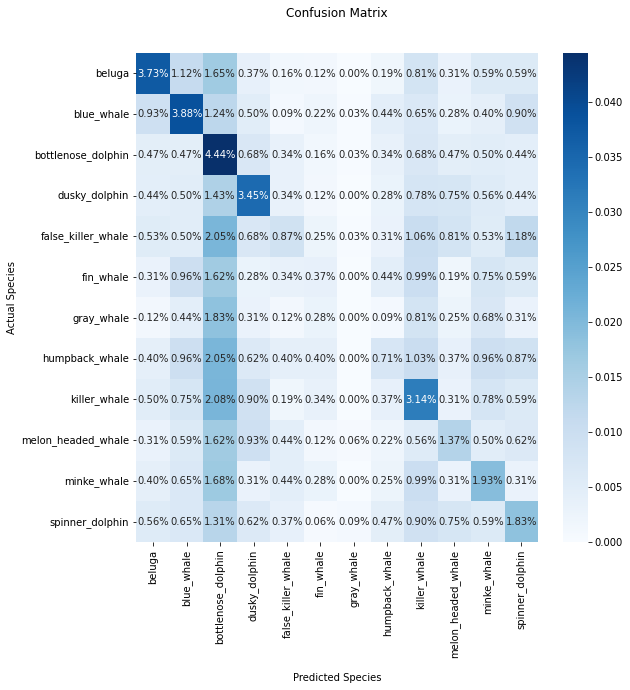

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sp_list = list(map(lambda x: x.split("species__")[-1],labels))

cm=confusion_matrix(y_act,y_pred)

plt.figure(figsize=(9, 9))
ax = sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Species')
ax.set_ylabel('Actual Species')

ax.xaxis.set_ticklabels(sp_list,rotation = 90)
ax.yaxis.set_ticklabels(sp_list, rotation = 360)


plt.show()

In [46]:
cval = current_model.evaluate(test_batched, verbose = 0)


wandb.log({"test loss" : cval[0]})
wandb.log({"test acc" : cval[1]})
wandb.log({"test error rate" : round((1-cval[1])*100,2)})
run.finish()


categorical_accuracy,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test acc,▁▁▁▁
test error rate,▁▁▁▁
test loss,▁▁▁▁
val_categorical_accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█▇▇███▇▇█
val_loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▂▁
best_epoch,37
best_val_loss,1.40345
categorical_accuracy,0.51186


In [ ]:
print("test loss, test acc:", cval)

In [ ]:
with open(f'seqnn.pkl', 'wb') as file:
    pickle.dump(current_model,file)

In [ ]:
"""

#visualize model performance
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
fig, (ax1, ax2) = plt.subplots(1, 2)

plt.figure(figsize=(15, 8))
ax1.plot(range(87), accuracy, "r", label="Training Accuracy")
ax1.plot(range(87), val_accuracy, "orange", label="Validation Accuracy")
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend(loc="lower left")

ax2.plot(range(87), loss, "b", label="Training Loss")
ax2.plot(range(87), val_loss, "g", label="Validation Loss")
ax2.grid(True)
ax2.legend(loc="lower left")
#plt.gca().set_ylim(0, 2)
"""